In [1]:
# ==== Task 2 — Config, Load, and Index ====
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

# Path to ratings_small.csv
DATA_PATH_T2 = Path(r"C:\Users\punna\Downloads\ratings_small.csv\ratings_small.csv")  # <-- change if needed

_fallback = Path("/mnt/data/ratings_small.csv")
if not DATA_PATH_T2.exists() and _fallback.exists():
    DATA_PATH_T2 = _fallback

OUT_DIR_T2 = Path("outputs/task2/plots")
OUT_DIR_T2.mkdir(parents=True, exist_ok=True)
Path("outputs/task2").mkdir(parents=True, exist_ok=True)

def load_ratings(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path)
    def pick(name):
        for c in df.columns:
            if c.lower() == name: 
                return c
        raise KeyError(f"Missing column '{name}'")
    u = pick("userid"); i = pick("movieid"); r = pick("rating")
    df = df[[u, i, r]].rename(columns={u:"userId", i:"movieId", r:"rating"})
    df["userId"] = df["userId"].astype(int)
    df["movieId"] = df["movieId"].astype(int)
    df["rating"] = df["rating"].astype(float)
    return df

ratings = load_ratings(DATA_PATH_T2)
print("Loaded:", len(ratings), "ratings;",
      "users:", ratings["userId"].nunique(), "items:", ratings["movieId"].nunique())

# Build fast indexes (maps)
def build_maps(df: pd.DataFrame):
    users = sorted(df["userId"].unique())
    items = sorted(df["movieId"].unique())
    u2i = {u:i for i,u in enumerate(users)}
    i2i = {m:i for i,m in enumerate(items)}
    R = np.full((len(users), len(items)), np.nan, dtype=float)
    # lists of (item, rating) per user and (user, rating) per item
    user_items = defaultdict(list)
    item_users = defaultdict(list)
    for (u, m, r) in df[["userId","movieId","rating"]].itertuples(index=False, name=None):
        ui, mi = u2i[u], i2i[m]
        R[ui, mi] = r
        user_items[ui].append((mi, r))
        item_users[mi].append((ui, r))
    return R, u2i, i2i, user_items, item_users

# 5-fold on interactions (stable split)
def kfold_indices(n, n_splits=5, seed=42):
    idx = np.arange(n)
    rng = np.random.default_rng(seed); rng.shuffle(idx)
    return np.array_split(idx, n_splits)


Loaded: 100004 ratings; users: 671 items: 9066


In [2]:
# ==== Task 2 — Similarities with caching ====
def cosine_sim(vec1, vec2, mask):
    if mask.sum() == 0: return 0.0
    a = vec1[mask]; b = vec2[mask]
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na == 0 or nb == 0: return 0.0
    return float((a @ b) / (na * nb))

def msd_sim(vec1, vec2, mask):
    if mask.sum() == 0: return 0.0
    dif = vec1[mask] - vec2[mask]
    msd = np.mean(dif**2)
    return float(1.0 / (1.0 + msd))

def pearson_sim(vec1, vec2, mask):
    if mask.sum() <= 1: return 0.0
    a = vec1[mask]; b = vec2[mask]
    a = a - a.mean(); b = b - b.mean()
    na, nb = np.linalg.norm(a), np.linalg.norm(b)
    if na == 0 or nb == 0: return 0.0
    return float((a @ b) / (na * nb))

SIM_BY_NAME = {"cosine": cosine_sim, "msd": msd_sim, "pearson": pearson_sim}


In [3]:
# ==== Task 2 — CF predictors with candidate indexing and similarity caching ====
def usercf_predict_many(R, user_items, item_users, test_triplets, sim_name="cosine", K=20, shrink=10.0):
    """
    Predict ratings for a list of (ui, mi, true_rating) using user-based CF.
    - Only considers candidate neighbors that rated the target item (fast).
    - Caches similarities (ui, v) for reuse across all test cases.
    - Returns arrays y_true, y_pred, and (optionally) per-case sorted neighbor lists for reuse in K-sweep.
    """
    sim_fn = SIM_BY_NAME[sim_name]
    y_true, y_pred = [], []
    # similarity cache keyed by (min(ui,v), max(ui,v), sim_name)
    sim_cache = {}

    # Precompute dense user vectors once (for masks)
    # NOTE: R is (n_users x n_items)
    for (ui, mi, r) in test_triplets:
        y_true.append(r)
        candidates = [u for (u, _) in item_users.get(mi, []) if u != ui]
        if not candidates:
            y_pred.append(np.nan); continue

        # Similarities to all candidates (reused from cache where possible)
        sims = []
        for v in candidates:
            a, b = min(ui, v), max(ui, v)
            key = (a, b, sim_name)
            if key in sim_cache:
                s = sim_cache[key]
            else:
                mask = ~np.isnan(R[ui]) & ~np.isnan(R[v])
                s = sim_fn(R[ui], R[v], mask)
                # simple shrinkage by overlap size
                overlap = int(mask.sum())
                s = (overlap / (overlap + shrink)) * s if overlap > 0 else 0.0
                sim_cache[key] = s
            if not np.isnan(R[v, mi]):
                sims.append((s, v))

        # Top-K neighbors
        if not sims:
            y_pred.append(np.nan); continue
        sims.sort(key=lambda t: t[0], reverse=True)
        top = sims[:K]

        num = 0.0; den = 0.0
        for s, v in top:
            rv = R[v, mi]
            if np.isnan(rv): 
                continue
            num += s * rv; den += abs(s)
        y_pred.append(num/den if den > 0 else np.nan)

    return np.array(y_true), np.array(y_pred)

def itemcf_predict_many(R, user_items, item_users, test_triplets, sim_name="cosine", K=20, shrink=10.0):
    """
    Predict ratings for a list of (ui, mi, true_rating) using item-based CF.
    - Only considers candidate neighbors that the user actually rated (fast).
    - Caches similarities (j, mi) for reuse across all test cases.
    """
    sim_fn = SIM_BY_NAME[sim_name]
    y_true, y_pred = [], []
    sim_cache = {}

    for (ui, mi, r) in test_triplets:
        y_true.append(r)
        candidates = [j for (j, _) in user_items.get(ui, []) if j != mi]
        if not candidates:
            y_pred.append(np.nan); continue

        sims = []
        for j in candidates:
            a, b = min(j, mi), max(j, mi)
            key = (a, b, sim_name)
            if key in sim_cache:
                s = sim_cache[key]
            else:
                mask = ~np.isnan(R[:, j]) & ~np.isnan(R[:, mi])
                s = sim_fn(R[:, j], R[:, mi], mask)
                overlap = int(mask.sum())
                s = (overlap / (overlap + shrink)) * s if overlap > 0 else 0.0
                sim_cache[key] = s
            if not np.isnan(R[ui, j]):
                sims.append((s, j))

        if not sims:
            y_pred.append(np.nan); continue
        sims.sort(key=lambda t: t[0], reverse=True)
        top = sims[:K]

        num = 0.0; den = 0.0
        for s, j in top:
            rj = R[ui, j]
            if np.isnan(rj): 
                continue
            num += s * rj; den += abs(s)
        y_pred.append(num/den if den > 0 else np.nan)

    return np.array(y_true), np.array(y_pred)


In [4]:
# ==== Task 2 — PMF (SGD) ====
def pmf_train(R, n_factors=20, n_epochs=25, lr=0.01, reg=0.05, seed=42):
    rng = np.random.default_rng(seed)
    n_users, n_items = R.shape
    U = 0.1 * rng.standard_normal((n_users, n_factors))
    V = 0.1 * rng.standard_normal((n_items, n_factors))
    obs = np.argwhere(~np.isnan(R))
    for _ in range(n_epochs):
        rng.shuffle(obs)
        for (u, i) in obs:
            r = R[u, i]
            pred = U[u] @ V[i]
            err = r - pred
            U[u] += lr * (err * V[i] - reg * U[u])
            V[i] += lr * (err * U[u] - reg * V[i])
    return U, V

def pmf_predict(U, V, ui, mi):
    return float(U[ui] @ V[mi])


In [5]:
# ==== Task 2 — Metrics & CV helpers ====
def rmse(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return float(np.sqrt(np.mean((y_true[mask] - y_pred[mask])**2))) if mask.sum() else float("nan")

def mae(y_true, y_pred):
    mask = ~np.isnan(y_true) & ~np.isnan(y_pred)
    return float(np.mean(np.abs(y_true[mask] - y_pred[mask]))) if mask.sum() else float("nan")

def eval_user_item_cf(df, mode="user", sim="cosine", K=20, seed=42):
    n = len(df)
    folds = kfold_indices(n, 5, seed)
    rm_list, mae_list = [], []
    for f in range(5):
        test_idx = folds[f]
        train_idx = np.hstack([folds[j] for j in range(5) if j != f])
        train = df.iloc[train_idx].reset_index(drop=True)
        test = df.iloc[test_idx].reset_index(drop=True)

        R, u2i, i2i, user_items, item_users = build_maps(train)
        # Build test triplets in matrix indices; skip cold-starts
        test_trip = []
        for (u, m, r) in test[["userId","movieId","rating"]].itertuples(index=False, name=None):
            if u in u2i and m in i2i:
                test_trip.append((u2i[u], i2i[m], r))
        if not test_trip:
            rm_list.append(np.nan); mae_list.append(np.nan); continue

        if mode == "user":
            y_true, y_pred = usercf_predict_many(R, user_items, item_users, test_trip, sim_name=sim, K=K)
        else:
            y_true, y_pred = itemcf_predict_many(R, user_items, item_users, test_trip, sim_name=sim, K=K)

        rm_list.append(rmse(y_true, y_pred))
        mae_list.append(mae(y_true, y_pred))
    return float(np.nanmean(rm_list)), float(np.nanstd(rm_list)), float(np.nanmean(mae_list)), float(np.nanstd(mae_list))

def eval_pmf(df, n_factors=20, n_epochs=25, seed=42):
    n = len(df)
    folds = kfold_indices(n, 5, seed)
    rm_list, mae_list = [], []
    for f in range(5):
        test_idx = folds[f]
        train_idx = np.hstack([folds[j] for j in range(5) if j != f])
        train = df.iloc[train_idx].reset_index(drop=True)
        test = df.iloc[test_idx].reset_index(drop=True)

        R, u2i, i2i, *_ = build_maps(train)
        U, V = pmf_train(R, n_factors=n_factors, n_epochs=n_epochs, seed=seed)

        y_true, y_pred = [], []
        for (u, m, r) in test[["userId","movieId","rating"]].itertuples(index=False, name=None):
            if u not in u2i or m not in i2i: 
                continue
            y_true.append(r)
            y_pred.append(pmf_predict(U, V, u2i[u], i2i[m]))

        y_true = np.array(y_true); y_pred = np.array(y_pred)
        rm_list.append(rmse(y_true, y_pred))
        mae_list.append(mae(y_true, y_pred))
    return float(np.nanmean(rm_list)), float(np.nanstd(rm_list)), float(np.nanmean(mae_list)), float(np.nanstd(mae_list))


,model,sim,K,rmse_mean,rmse_std,mae_mean,mae_std
0,usercf,cosine,20,0.990201,0.004190,0.771672,0.002106
1,itemcf,cosine,20,1.003427,0.008022,0.756266,0.005017
2,pmf,-,-,0.928389,0.004900,0.714168,0.004661


<Figure size 640x480 with 0 Axes>

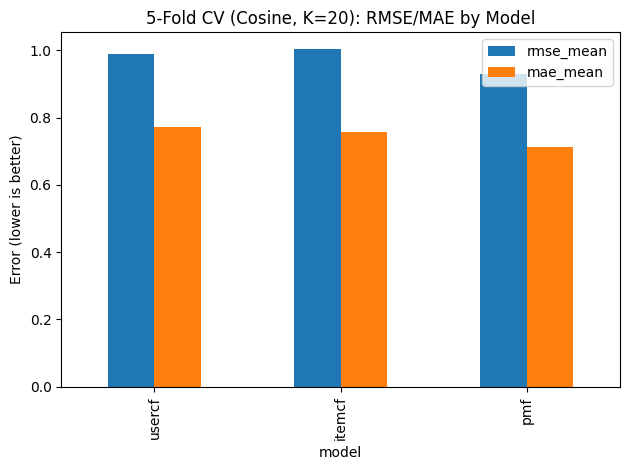

In [6]:
# ==== Task 2 — (c) 5-fold CV: PMF vs UserCF vs ItemCF ====
rows = []

rm, rs, mm, ms = eval_user_item_cf(ratings, mode="user", sim="cosine", K=20, seed=42)
rows.append({"model":"usercf","sim":"cosine","K":20,"rmse_mean":rm,"rmse_std":rs,"mae_mean":mm,"mae_std":ms})

rm, rs, mm, ms = eval_user_item_cf(ratings, mode="item", sim="cosine", K=20, seed=42)
rows.append({"model":"itemcf","sim":"cosine","K":20,"rmse_mean":rm,"rmse_std":rs,"mae_mean":mm,"mae_std":ms})

rm, rs, mm, ms = eval_pmf(ratings, n_factors=20, n_epochs=25, seed=42)
rows.append({"model":"pmf","sim":"-", "K":"-", "rmse_mean":rm,"rmse_std":rs,"mae_mean":mm,"mae_std":ms})

cv_metrics = pd.DataFrame(rows)
cv_metrics.to_csv("outputs/task2/cv_metrics.csv", index=False)
display(cv_metrics)

fig = plt.figure()
cv_metrics.plot(kind="bar", x="model", y=["rmse_mean","mae_mean"])
plt.title("5-Fold CV (Cosine, K=20): RMSE/MAE by Model")
plt.ylabel("Error (lower is better)")
plt.tight_layout(); plt.savefig(OUT_DIR_T2 / "cv_metrics.png"); plt.show()


,model,sim,K,rmse_mean,rmse_std,mae_mean,mae_std
0,usercf,cosine,20,0.990201,0.004190,0.771672,0.002106
1,usercf,msd,20,0.950123,0.004875,0.730257,0.002867
2,usercf,pearson,20,1.421664,0.013594,0.979670,0.007840
3,itemcf,cosine,20,1.003427,0.008022,0.756266,0.005017
4,itemcf,msd,20,0.893592,0.006953,0.674676,0.004968
5,itemcf,pearson,20,0.994365,0.010882,0.741135,0.005813


<Figure size 640x480 with 0 Axes>

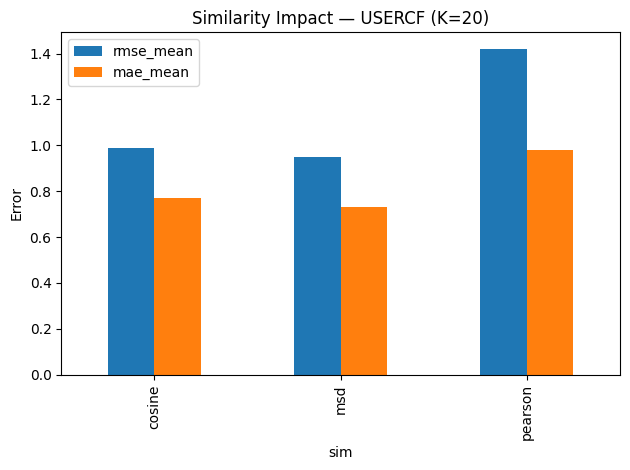

<Figure size 640x480 with 0 Axes>

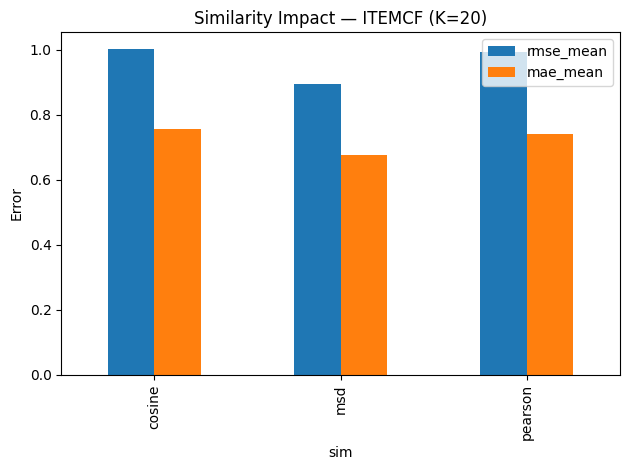

In [7]:
# ==== Task 2 — (e) Similarity Impact for UserCF & ItemCF ====
sim_rows = []
for mode in ["user", "item"]:
    for sim in ["cosine", "msd", "pearson"]:
        rm, rs, mm, ms = eval_user_item_cf(ratings, mode=mode, sim=sim, K=20, seed=42)
        sim_rows.append({"model": f"{mode}cf", "sim": sim, "K": 20, 
                         "rmse_mean": rm, "rmse_std": rs, "mae_mean": mm, "mae_std": ms})

sim_df = pd.DataFrame(sim_rows)
sim_df.to_csv("outputs/task2/similarity_sweep.csv", index=False)
display(sim_df)

for mode in ["user", "item"]:
    sub = sim_df[sim_df["model"] == f"{mode}cf"]
    fig = plt.figure()
    sub.plot(kind="bar", x="sim", y=["rmse_mean","mae_mean"])
    plt.title(f"Similarity Impact — {mode.upper()}CF (K=20)")
    plt.ylabel("Error")
    plt.tight_layout(); plt.savefig(OUT_DIR_T2 / f"sim_{mode}cf.png"); plt.show()


,model,sim,K,rmse_mean,rmse_std,mae_mean,mae_std
7,itemcf,cosine,5,1.075976,0.008793,0.809385,0.005925
8,itemcf,cosine,10,1.033820,0.009407,0.778946,0.005947
9,itemcf,cosine,20,1.003427,0.008022,0.756266,0.005017
10,itemcf,cosine,30,0.989336,0.008106,0.746910,0.005445
11,itemcf,cosine,40,0.981052,0.007916,0.741415,0.005880
12,itemcf,cosine,60,0.971531,0.007912,0.736178,0.006088
13,itemcf,cosine,80,0.966292,0.007737,0.733586,0.006154
0,usercf,cosine,5,1.020527,0.006396,0.798164,0.003279
1,usercf,cosine,10,0.998294,0.003736,0.779847,0.002270
2,usercf,cosine,20,0.990201,0.004190,0.771672,0.002106


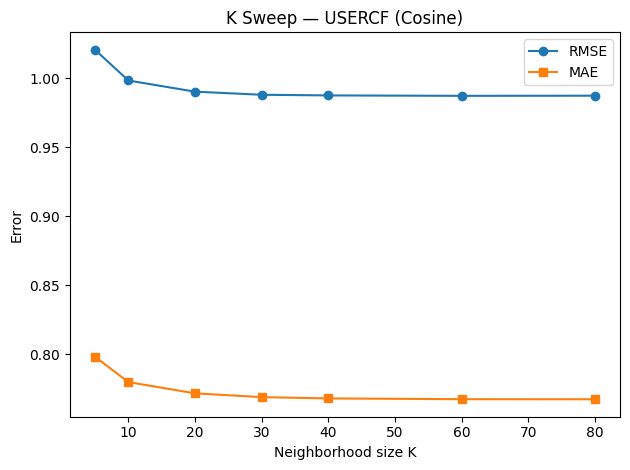

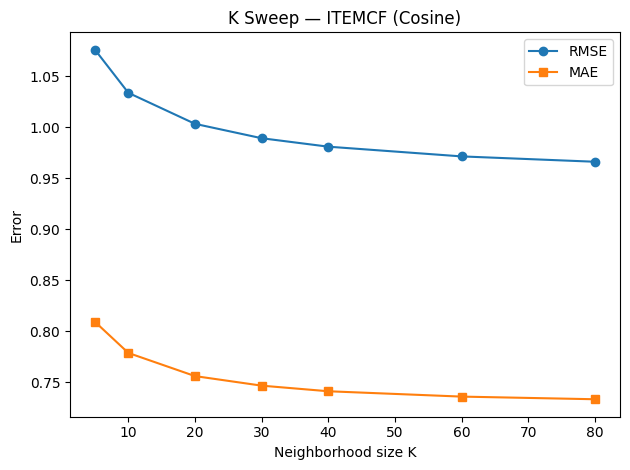

Best K (User-CF): {'K': np.int64(60), 'rmse_mean': np.float64(0.9871850084546473), 'mae_mean': np.float64(0.7674342915502993)}
Best K (Item-CF): {'K': np.int64(80), 'rmse_mean': np.float64(0.9662915399517708), 'mae_mean': np.float64(0.7335862303375965)}


In [8]:
# ==== Task 2 — (f) K-sweep (cosine) & (g) Best-K ====
k_rows = []
K_LIST = [5, 10, 20, 30, 40, 60, 80]

for mode in ["user", "item"]:
    for K in K_LIST:
        rm, rs, mm, ms = eval_user_item_cf(ratings, mode=mode, sim="cosine", K=K, seed=42)
        k_rows.append({"model": f"{mode}cf", "sim":"cosine", "K": K,
                       "rmse_mean": rm, "rmse_std": rs, "mae_mean": mm, "mae_std": ms})

k_df = pd.DataFrame(k_rows)
k_df.to_csv("outputs/task2/k_sweep.csv", index=False)
display(k_df.sort_values(["model","K"]))

for mode in ["user", "item"]:
    sub = k_df[k_df["model"]==f"{mode}cf"].sort_values("K")
    fig = plt.figure()
    plt.plot(sub["K"], sub["rmse_mean"], marker="o", label="RMSE")
    plt.plot(sub["K"], sub["mae_mean"], marker="s", label="MAE")
    plt.xlabel("Neighborhood size K"); plt.ylabel("Error")
    plt.title(f"K Sweep — {mode.upper()}CF (Cosine)")
    plt.legend()
    plt.tight_layout(); plt.savefig(OUT_DIR_T2 / f"k_{mode}cf.png"); plt.show()

# Report best K per model for (g)
best_user = k_df[k_df["model"]=="usercf"].sort_values("rmse_mean").iloc[0][["K","rmse_mean","mae_mean"]]
best_item = k_df[k_df["model"]=="itemcf"].sort_values("rmse_mean").iloc[0][["K","rmse_mean","mae_mean"]]
print("Best K (User-CF):", dict(best_user))
print("Best K (Item-CF):", dict(best_item))
